In [2]:
import py_compile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from dotenv import load_dotenv

from mymodule.myfunc import *
load_dotenv()
data_dir = os.environ["bigendian_data"]
imgout = os.environ["imgout"]
root_dir = os.environ["root_dir"]
snaps_dir = os.environ["snaps_dir"]


C:/Users/lkxl1/OneDrive/デスクトップ/research/bigendian_data/


# ロードとヒートマップの出力

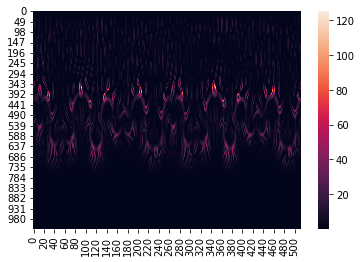

In [5]:
#for で回す時、保存は全てできるが、表示は最後のみ
for target in ["velocityy", "magfieldy", "density", "enstrophy"]:
    for job in [0,2,4,6,8,10,12,14]:
        for n in [1]:
            # name = f"{snaps_dir}{target}/{job}/{target}.{'{0:02d}'.format(para)}.{'{0:02d}'.format(job)}"
            name = gen_snap_path(target,n,job)
            data = load(name ,z=3)
            # show(data, imgname=f"{imgout}0930/{target}.{n}.{job}.png")
            show(data)


# エッジの表示

[[227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]
 ...
 [227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]]


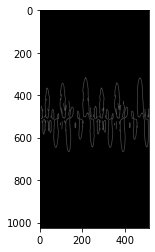

In [3]:
target = "velocityx"
para = 1
job = 5

name = gen_snap_path(target,para,job)
data = load(name ,z=3)
#cv2で扱える0-255の整数に整形
data = ((data - min(data.flat))*254/max(data.flat))
data = data.astype("uint8")
print(data)
edges = cv2.Canny(data, threshold1=150, threshold2=200)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
#cv2.imwrite('edges.jpg', edges)

# 流線

参考 https://python-pyramid.com/?p=143

result   Y,X: 511 255
original Y,X: (1025, 513)
result   Y,X: 511 255
original Y,X: (1025, 513)


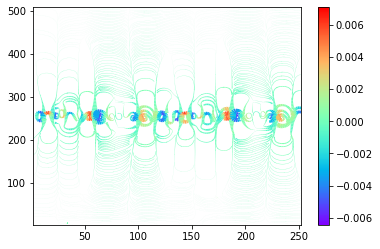

In [4]:
targetX = "velocityx"
targetY = "velocityy"
para = 1
job = 5

name = gen_snap_path(target,para,job)
dataX = load(gen_snap_path(targetX,para,job),z=3)
dataY = load(gen_snap_path(targetY,para,job), z=3)

#計算が重いので平滑化フィルターの畳み込みで圧縮
carnel1 = ave_carnel(4)
carnel2 = carnel1.T
dataX = convolute(dataX, carnel2,stride=2)
dataY = convolute(dataY, carnel1,stride=2)

x = range(dataX.shape[1])
y = range(dataY.shape[0])
#X,Y方向それぞれのベクトルに対して座標の行列を設定
X, Y = np.meshgrid(x, y)
#X,Y方向それぞれのベクトルの強さ
u = dataX
v = dataY

# print(X.shape)
# print(Y.shape)
# print(u.shape)
# print(v.shape)
color = u**2 + v**2
color = color*2/max(color.flat)

#########
rot = rot2d(u, v)
u = u[2:-2,2:-2]
v = v[2:-2,2:-2]
X = X[2:-2,2:-2]
Y = Y[2:-2,2:-2]
##########

speed = np.sqrt(u**2 + v**2)
lw = 7*speed / speed.max()

fig = plt.figure(1)
#plt.contour(X,Y,speed)
#sns.heatmap(dataY)
#strm = plt.streamplot(X, Y, u, v, density=[5], color=color, arrowstyle='-', linewidth=1,cmap="rainbow")
strm = plt.streamplot(X, Y, u, v, density=[5], color=rot, arrowstyle='-', linewidth=lw,cmap="rainbow")
#strm = plt.streamplot(X, Y, u, v, density=[1,5], color=black, arrowstyle='-|>', linewidth=1)
# plt.savefig("v_stream3.png")
fig.colorbar(strm.lines)
plt.show()


# エネルギー

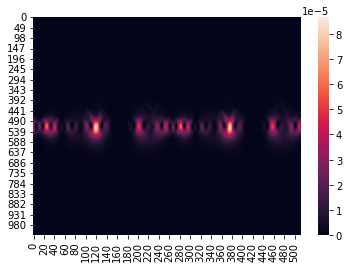

In [9]:
# 速さと密度について
dens = load(gen_snap_path("density",para,job),z=3)
vX = load(gen_snap_path("velocityX",para,job),z=3)
vY = load(gen_snap_path("velocityY",para,job),z=3)

energy = dens * (vX**2 + vY**2) / 2
show(energy)

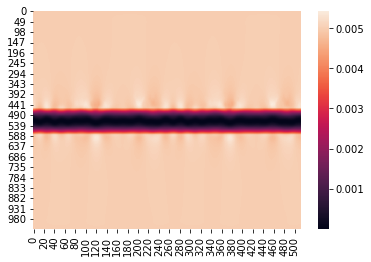

In [10]:
# 磁場について

bX = load(gen_snap_path("magfieldX",para,job),z=3)
bY = load(gen_snap_path("magfieldY",para,job),z=3)

bhoge = (bX**2 + bY**2)/2
show(bhoge)

# ローテーション

In [4]:
#関数の微分でローテーション
import sympy as sp
sp.var(' x y z ')#いる？
from sympy.core.function import Function


v1 = Function('v1')(x,y,z)
v2 = Function('v2')(x,y,z)
v3 = Function('v3')(x,y,z)
V = sp.Matrix([[v1],[v2],[v3]])
def rot(V):
    return sp.Matrix([
        [sp.diff(V[2,0],y)-sp.diff(V[1,0],z)],
        [sp.diff(V[0,0],z)-sp.diff(V[2,0],x)],
        [sp.diff(V[1,0],x)-sp.diff(V[0,0],y)]])
rot(V)

Matrix([
[-Derivative(v2(x, y, z), z) + Derivative(v3(x, y, z), y)],
[ Derivative(v1(x, y, z), z) - Derivative(v3(x, y, z), x)],
[-Derivative(v1(x, y, z), y) + Derivative(v2(x, y, z), x)]])

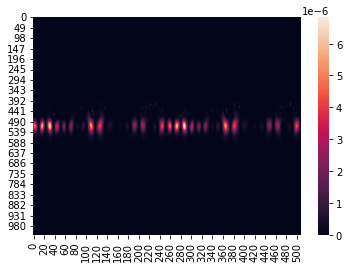

In [11]:
vX = load(gen_snap_path("velocityX",para,job),z=3)
vY = load(gen_snap_path("velocityY",para,job),z=3)
vZ = load(gen_snap_path("velocityZ",para,job),z=3)
show((rot2d(vX,vY)**2)/2)
# diff4_y(vX,1)